#### 从数据库导入数据

In [1]:
import pymysql.cursors
import pandas as pd

db = pymysql.connect(host='localhost',user='root',password='root',db='lagou',charset='utf8',cursorclass=pymysql.cursors.DictCursor)
cursor = db.cursor()
sql = 'SELECT * FROM dataset;'
cursor.execute(sql)
result = cursor.fetchall()
df = pd.DataFrame(list(result))
db.close()

df

,jobNature,companySize,workYear,education,industryField,thirdType,salaryMin,salaryMax,nameUnfit,positionId,...,financeStage,firstType,secondType,district,salary,resumeProcessRate,resumeProcessDay,score,famousCompany,isFocus
0,全职,500-2000人,1-3年,本科,旅游,数据分析,18,35,0,6112946,...,D轮及以上,开发|测试|运维类,数据开发,福田区,18k-35k,100,1,199,0,1
1,全职,500-2000人,3-5年,本科,"消费生活,移动互联网",商业,15,25,0,6229664,...,C轮,产品|需求|项目类,数据分析,南山区,15k-25k,100,1,179,0,1
2,全职,2000人以上,5-10年,本科,金融,建模,15,30,0,6853427,...,上市公司,开发|测试|运维类,数据开发,福田区,15k-30k,100,1,130,1,0
3,全职,2000人以上,1-3年,本科,金融,Hadoop,20,30,0,6692363,...,不需要融资,开发|测试|运维类,数据开发,南山区,20k-30k,100,2,89,0,0
4,全职,2000人以上,1-3年,大专,"移动互联网,游戏",数据分析,8,10,0,6835783,...,不需要融资,产品|需求|项目类,数据分析,南山区,8k-10k,0,1,69,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,全职,2000人以上,3-5年,本科,社交,产品经理,15,25,1,5276304,...,上市公司,产品|需求|项目类,产品经理,南山区,15k-25k,100,1,10,1,0
271,全职,2000人以上,3-5年,本科,社交,数据挖掘,18,35,0,6842800,...,上市公司,开发|测试|运维类,数据开发,南山区,18k-35k,100,1,10,1,1
272,全职,2000人以上,3-5年,本科,社交,数据分析,20,40,0,5250466,...,上市公司,产品|需求|项目类,数据分析,南山区,20k-40k,100,1,10,1,1
273,全职,2000人以上,1-3年,本科,金融,数据分析,20,30,0,6391267,...,未融资,开发|测试|运维类,数据开发,南山区,20k-30k,15,1,4,1,0


#### 拆分训练集和测试集

In [2]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1]
X = pd.get_dummies(X).values
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [3]:
X_names = pd.get_dummies(df.iloc[:,:-1]).columns
X_names

Index(['salaryMin', 'salaryMax', 'nameUnfit', 'resumeProcessRate',
       'resumeProcessDay', 'score', 'famousCompany', 'jobNature_全职',
       'jobNature_兼职', 'jobNature_实习',
       ...
       'salary_7k-13k', 'salary_7k-14k', 'salary_8k-10k', 'salary_8k-11k',
       'salary_8k-12k', 'salary_8k-13k', 'salary_8k-15k', 'salary_8k-16k',
       'salary_9k-12k', 'salary_9k-14k'],
      dtype='object', length=687)

### 特征重要性排序（方式一）

In [11]:
?permutation_importance

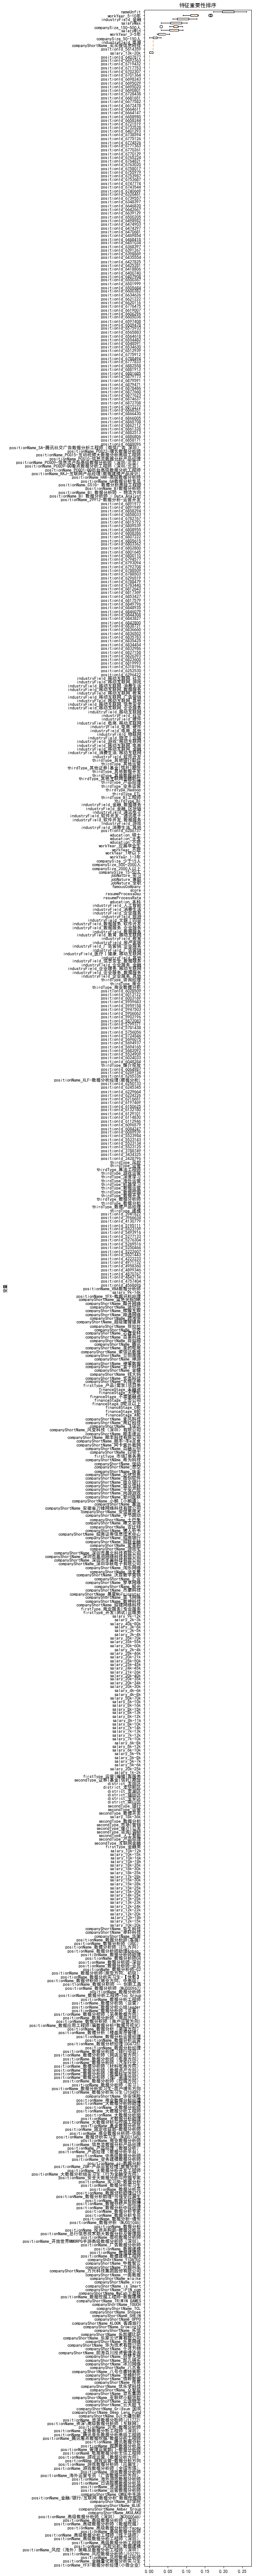

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

result = permutation_importance(gbc, X_train, y_train, scoring='f1', n_repeats=10, random_state=42, n_jobs=-1)
fig, ax = plt.subplots(figsize=(8, 80))
sorted_idx = result.importances_mean.argsort()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_names[sorted_idx])
ax.set_title('特征重要性排序')
ax.set_ylabel('变量')
fig.tight_layout()

plt.savefig(r"D:\Jupyter\Data\importances1.png",dpi=800)
plt.show()

### 特征重要性排序（方式二）

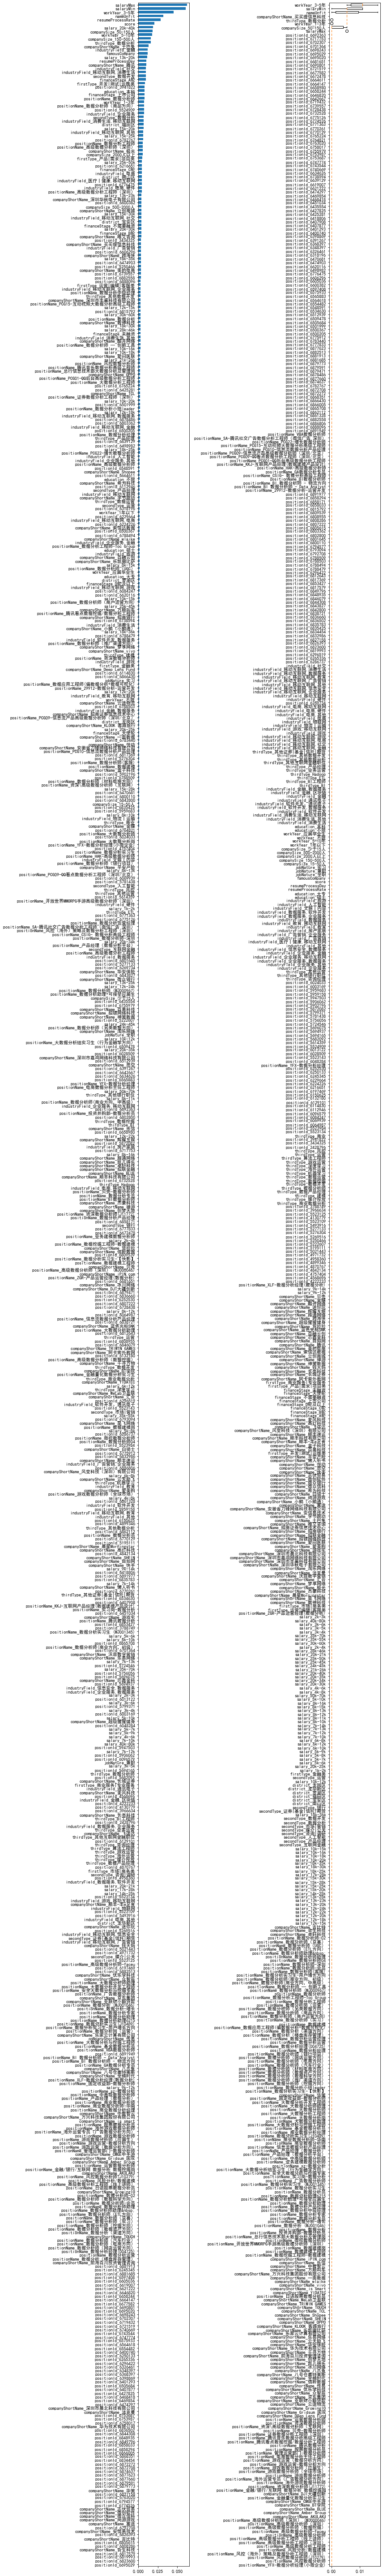

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import numpy as np
from matplotlib import pyplot as plt

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

result = permutation_importance(rfc, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rfc.feature_importances_)
tree_indices = np.arange(0, len(rfc.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,80))
ax1.barh(tree_indices, rfc.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(X_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(rfc.feature_importances_)))
ax2.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_names[sorted_idx])
fig.tight_layout()

plt.savefig(r"D:\Jupyter\Data\importances2.png",dpi=800)
plt.show()